# Recording BOLD signals

This notebook demonstrates the usage of the BOLD monitoring extension.

## Background

ANNarchy pre-implements some model variants of the BOLD models presented in Stephan et al. (2007) which are variations of the Balloon Model originally designed by Buxton et al. (1998). The four balloon variants model pre-implemented in ANNarchy follow the naming scheme of Stephan et al. (2007). The model name starts with *balloon_* followed by either *C* (i. e. classical coefficient) or *R* (i. e. revised coefficient) and then followed by either *N* which means non-linear BOLD equation or *L* which means linear bold equation.

We only provide here the equations without much explanations, for more details please refer to the literature:

> Buxton, R. B., Wong, E. C., and Frank, L. R. (1998). Dynamics of blood flow and oxygenation changes during brain activation: the balloon model. Magnetic resonance in medicine 39, 855–864. doi:10.1002/mrm.1910390602

>  Friston et al. (2000). Nonlinear responses in fMRI: the balloon model, volterra kernels, and other hemodynamics. NeuroImage 12, 466–477

>  Buxton et al. (2004). Modeling the hemodynamic response to brain activation. Neuroimage 23, S220–S233. doi:10.1016/j.neuroimage.2004.07.013

>  Stephan et al. (2007). Comparing hemodynamic models with DCM. Neuroimage 38, 387–401. doi:10.1016/j.neuroimage.2007.07.040

>  Maith et al. (2021) A computational model-based analysis of basal ganglia pathway changes in Parkinson’s disease inferred from resting-state fMRI. European Journal of Neuroscience. 2021; 53: 2278– 2295. doi:10.1111/ejn.14868 


## Single input Balloon model

This script shows a simple example for the application of one of the default models (the *balloon_RN* model) on a simple network. The *balloon_RN* model is described by the following equations:

$$
    \tau \cdot \frac{ds}{dt} = \phi \cdot I_\text{CBF} - \kappa \cdot s - \gamma \cdot (f_{in} - 1)
$$

$$
    \frac{df_{in}}{dt} = s
$$

$$
    E = 1 - (1 - E_{0})^{ \frac{1}{f_{in}} }
$$

$$
    \tau \cdot \frac{dv}{dt} = \frac{1}{\tau_0} \cdot (f_{in} - f_{out})
$$

$$
    f_{out} = v^{\frac{1}{\alpha}}
$$

$$
    \tau \cdot \frac{dq}{dt} = \frac{1}{\tau_0} \cdot ( f_{in} \cdot \frac{E}{E_0} - \frac{q}{v} \cdot f_{out} )
$$

with revised coefficients and non-linear bold equation:

$$k_1            = 4.3 \, v_0 \, E_0 \, \text{TE}$$

$$k_2            = \epsilon \, r_0 \, E_0 \, \text{TE}$$

$$k_3            = 1 - \epsilon$$

$$
    BOLD = v_0 \cdot ( k_1 \cdot (1-q) + k_2 \cdot (1 - \dfrac{q}{v}) + k_3 \cdot (1 - v) )
$$

There are two important variables in that model: `BOLD` which is the output of the model and `I_CBF` which is the input signal, reflecting the mean firing rate of the input populations.

As the BOLD model reflects the change of activity levels in the recorded area, we will implement the following experiment. We record from two populations with 100 Izhikevich neurons each. After a short period of time we raise the activity level of one population for a fixed time window. For simplicity, we do not use connections between the neurons but simply increase the noise term in the Izhikevich model. This should lead to a noticeable BOLD signal.

### Populations

For this example we want to create two groups of Izhikevich neurons:

In [1]:
from ANNarchy import *
from ANNarchy.extensions.bold import *
clear()

# A population of 100 izhikevich neurons
pop0 = Population(100, neuron=Izhikevich)
pop1 = Population(100, neuron=Izhikevich)

ANNarchy 4.7 (4.7.0) on linux (posix).


As we will not have any connections between the neurons, we need to increase the noise to create some baseline activity:

In [2]:
# Set noise to create some baseline activity
pop0.noise = 5.0; pop1.noise = 5.0

To evaluate the result of the simulation we want to investigate the mean firing rate of the neurons. This need to be activated explicitely as the computation of this value is quite expensive. In our example, the mean firing rate should be computed across a time window of 100 ms. The resulting value will be stored in the `r` attribute of the populations and can be easily recorded.

In [3]:
# Compute mean firing rate in Hz on 100ms window
pop0.compute_firing_rate(window=100.0)
pop1.compute_firing_rate(window=100.0)

# Record the mean firing rate
mon_pop0 = Monitor(pop0, ["r"], start=False)
mon_pop1 = Monitor(pop1, ["r"], start=False)

### BOLD Monitor definition

The BOLD monitor expects a list of populations which we want to record (in our case `pop0` and `pop1`). A BOLD model should be specified, here we atke `balloon_RN` which is the default. We then specify the mapping from the population variable that should influence the BOLD signal, in our case the mean firing rate `r`, to the input variable of the BOLD model `I_CBF`. 

The mean firing rate is normalized over a time window of 2000 ms and we record both input and output signals:

In [4]:
m_bold = BoldMonitor(
    
    populations = [pop0, pop1],               # recorded populations
    
    bold_model = balloon_RN(),                # BOLD model to use (default is balloon_RN)
    
    mapping = {'I_CBF': 'r'},
    
    normalize_input = 2000,                   # time window to compute baseline. It should be a multiple of the window used for the mean firing rate.
    
    recorded_variables = ["I_CBF", "BOLD"]        # we want to analyze the BOLD input
)

Now we can compile and initialize the network:

In [5]:
compile()

Compiling ...  OK 


### Simulation

We first simulate 1 second biological time to ensure that the network reaches a stable firing rate:

In [6]:
# Ramp up time
simulate(1000)

We then enable the recording of all monitors:

In [7]:
# Start recording
mon_pop0.start()
mon_pop1.start()
m_bold.start()

We simulate for 5 seconds with lower noise and we increase the noise in `pop0` for 5 seconds before decreasing it again:

In [8]:
# we manipulate the noise for the half of the neurons
simulate(5000)      # 5s with low noise
pop0.noise = 7.5
simulate(5000)      # 5s with higher noise (one population)
pop0.noise = 5
simulate(10000)     # 10s with low noise

# Retrieve the recordings
mean_fr1 = np.mean(mon_pop0.get("r"), axis=1)
mean_fr2 = np.mean(mon_pop1.get("r"), axis=1)

input_data = m_bold.get("I_CBF")
bold_data = m_bold.get("BOLD")

### Evaluation

We can now plot:

* the mean firing rate in the input populations.
* the recorded activity `I` which serves as an input to the BOLD model.
* the resulting BOLD signal.

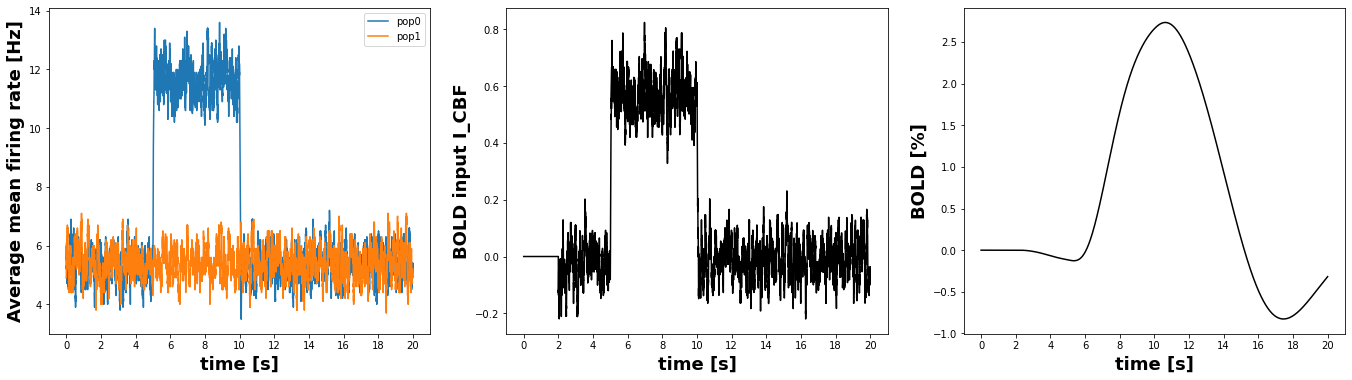

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])

ax1.plot(mean_fr1, label="pop0")
ax1.plot(mean_fr2, label="pop1")
plt.legend()
ax1.set_ylabel("Average mean firing rate [Hz]", fontweight="bold", fontsize=18)

# BOLD input signal
ax2 = plt.subplot(grid[0, 1])

ax2.plot(input_data, color="k")
ax2.set_ylabel("BOLD input I_CBF", fontweight="bold", fontsize=18)

# BOLD output signal
ax3 = plt.subplot(grid[0, 2])

ax3.plot(bold_data*100.0, color="k")
ax3.set_ylabel("BOLD [%]", fontweight="bold", fontsize=18)

# x-axis labels as seconds
for ax in [ax1, ax2, ax3]:
    ax.set_xticks(np.arange(0,21,2)*1000)
    ax.set_xticklabels(np.arange(0,21,2))
    ax.set_xlabel("time [s]", fontweight="bold", fontsize=18)

plt.show()

## Two inputs Balloon model

Let's now see the effect of a two-inputs model using both the firing rate and the membrane potential of the populations as inputs. We first need to recreate the network, as the BOLD monitors are compiled and cannot be created afterwards:

In [10]:
clear()

# Two populations of 100 izhikevich neurons
pop0 = Population(100, neuron=Izhikevich)
pop1 = Population(100, neuron=Izhikevich)

# Set noise to create some baseline activity
pop0.noise = 5.0; pop1.noise = 5.0

# Compute mean firing rate in Hz on 100ms window
pop0.compute_firing_rate(window=100.0)
pop1.compute_firing_rate(window=100.0)

# Create required monitors
mon_pop0 = Monitor(pop0, ["r"], start=False)
mon_pop1 = Monitor(pop1, ["r"], start=False)

m_bold = BoldMonitor(
    
    populations = [pop0, pop1],               # recorded populations
    
    bold_model = balloon_two_inputs(),        # BOLD model to use 
    
    # mean firing rate as source variable coupled to the input variable I_CBF
    # membrane potential as source variable coupled to the input variable I_CMRO2
    mapping={'I_CBF': 'r','I_CMRO2': 'v'},            
    
    normalize_input=2000,                   # time window to compute the baseline
    
    recorded_variables=["I_CBF", "I_CMRO2", "BOLD"] # we want to analyze the BOLD model input
)

compile()

Compiling ...  OK 


In [11]:
# Ramp up time
simulate(1000)

# Start recording
mon_pop0.start()
mon_pop1.start()
m_bold.start()

# we manipulate the noise for the half of the neurons
simulate(5000)      # 5s with low noise
pop0.noise = 7.5
simulate(5000)      # 5s with higher noise (one population)
pop0.noise = 5
simulate(10000)     # 10s with low noise

# retrieve the recordings
mean_fr1 = np.mean(mon_pop0.get("r"), axis=1)
mean_fr2 = np.mean(mon_pop1.get("r"), axis=1)

If_data = m_bold.get("I_CBF")
Ir_data = m_bold.get("I_CMRO2")
bold_data = m_bold.get("BOLD")

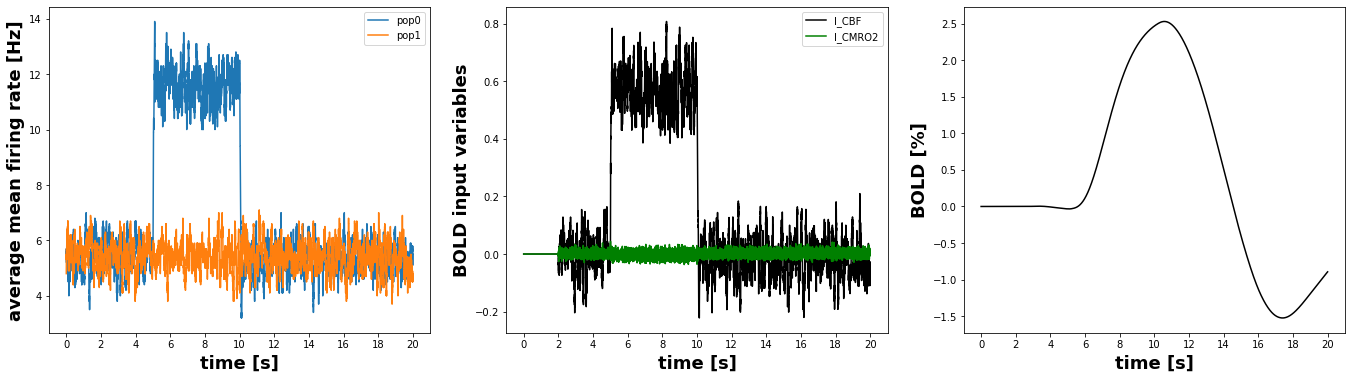

In [12]:
plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])
ax1.plot(mean_fr1, label="pop0")
ax1.plot(mean_fr2, label="pop1")
plt.legend()
ax1.set_ylabel("average mean firing rate [Hz]", fontweight="bold", fontsize=18)

# BOLD input signal
ax2 = plt.subplot(grid[0, 1])

ax2.plot(If_data, color="k", label='I_CBF')
ax2.plot(Ir_data, color="g", label='I_CMRO2')
ax2.set_ylabel("BOLD input variables", fontweight="bold", fontsize=18)
ax2.legend()

# BOLD input signal as percent
ax3 = plt.subplot(grid[0, 2])
ax3.plot(bold_data*100.0, color="k")
ax3.set_ylabel("BOLD [%]", fontweight="bold", fontsize=18)

# x-axis labels as seconds
for ax in [ax1, ax2, ax3]:
    ax.set_xticks(np.arange(0,21,2)*1000)
    ax.set_xticklabels(np.arange(0,21,2))
    ax.set_xlabel("time [s]", fontweight="bold", fontsize=18)

plt.show()